In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch as pt

from models.common import PUPieAPPPatch
from loader.dataset import ImageLoader, image2patches

%matplotlib inline

In [2]:
# Path to reference and distorted iamges
path_reference_image = './example_images/sdr_ref_1.bmp'
path_test_image ='./example_images/sdr_test_1.bmp'
dynamic_range = 'sdr'

# Parameters of the display model (Assuming peak and black level of a display on which LDR image is shown).
# Set to 100 and 0.5 if unsure. The parameter is not used for HDR images as these are given in luminance values.
lum_top = 100
lum_bottom = 0.5

# The quality assessment model operates on 64x64 patches sampled on a regular grid. 
# The shift specifies the window shift for sampling the patchs. The smaller the shift the more accurate the model is.
stride = 16
saved_state_model = './pupieapp_weights.pt'
state = pt.load(saved_state_model, map_location='cpu')

# Create and load the model
net = PUPieAPPPatch(state)
net.eval()


loader = ImageLoader()


# Visualise errormap

The network takes a set of 64x64 image patches extracted from an image in a grid fashion. It applies the display model, PU transform and normalises every patch between 0 and 1 internally. The network takes as input image patches, dynamic range and top and bottom luminance of the display the image is shown on. If the image is an hdr image, the networks needs no top/bottom luminance parameters.

As an output the network produces overall image score and per-patch scores and weights, which can then be visuallised as a weighted error map.

/Users/aliaksei/Documents/upiq/loader/dataset.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reference_patches.append(pt.tensor(
/Users/aliaksei/Documents/upiq/loader/dataset.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_patches.append(pt.tensor(


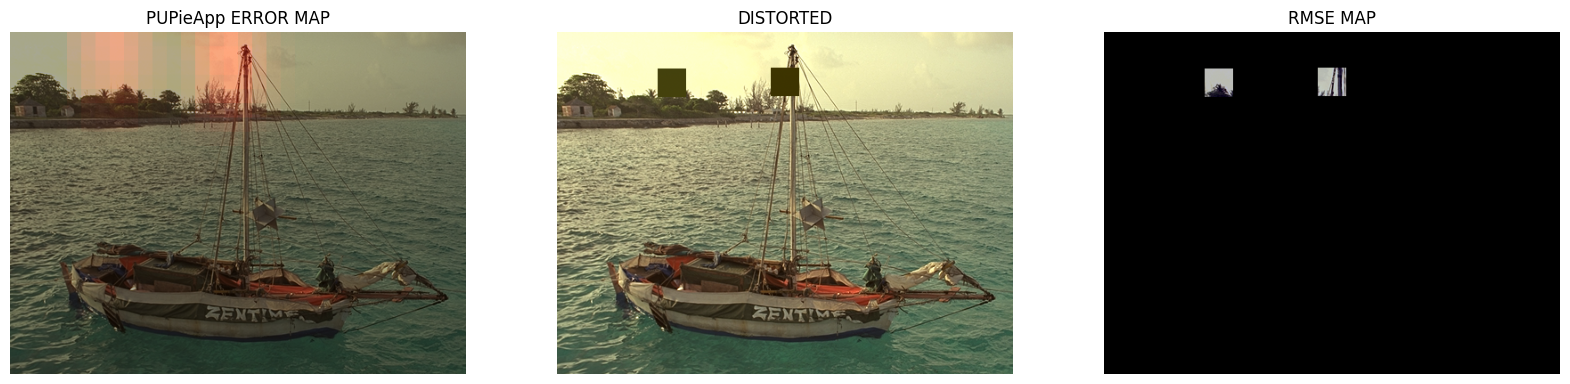

In [3]:
# Read images and split them into patches (note: no processing is applied). 
image_ref = imageio.imread(path_reference_image)
image_ref = pt.from_numpy(imageio.core.asarray(image_ref))
image_ref = image_ref.permute(2,0,1)

image_test = imageio.imread(path_test_image)
image_test = pt.from_numpy(imageio.core.asarray(image_test))
image_test = image_test.permute(2,0,1)

ref_patches, img_patches, weights = image2patches(reference = image_ref,image = image_test, shift_patch= stride)


# Run the network with no gradient
with pt.no_grad():
    score, per_patch_score, per_patch_weight  = net(ref_patches, img_patches,im_type=dynamic_range, lum_top=lum_top, lum_bottom=lum_bottom)
    
      
# Plot the error map
    
# Re-normalise the weight and the score between 0 and 1
pp_score = np.squeeze(per_patch_score.cpu().numpy())
pp_weight = np.squeeze(per_patch_weight.cpu().numpy())
pp_weight_n = (pp_weight-np.min(pp_weight))/np.max(pp_weight -np.min(pp_weight))
pp_score_n =  1-(pp_score-np.min(pp_score))/np.max((pp_score-np.min(pp_score)))

# Assemble the image from the image patches and create an error map of the image patche scores, weighted by the patch weight
image_ref,  error_map = loader.create_error_map(ref_patches.numpy(),weights,pp_score_n,pp_weight_n,shift_patch=stride)
image_dist, error_map = loader.create_error_map(img_patches.numpy(),weights,pp_score_n,pp_weight_n,shift_patch=stride)

# Set up the error map - blend it with the image: blend - blending parameter: how much of an image and how much of the
# error map is displayed.
blend = 0.8
error_map[1:3,:,:] = 0.0  
PUPieApp_blended_error_map = np.add(error_map*2*blend, (1-blend)*image_ref/255*3)

plt.figure(figsize=(20, 6), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(np.transpose(PUPieApp_blended_error_map/PUPieApp_blended_error_map.max(),(1,2,0)));
plt.axis('off')
plt.title('PUPieApp ERROR MAP')

plt.subplot(132)
plt.imshow(np.transpose(image_dist/image_dist.max(),(1,2,0)));
plt.axis('off')
plt.title('DISTORTED')

plt.subplot(133)
plt.imshow(np.transpose(np.sqrt((image_ref/image_ref.max()-image_dist/image_dist.max())**2),(1,2,0)))
plt.axis('off')
plt.title('RMSE MAP');

#plt.savefig("example_error_map_pupieapp.png", bbox_inches='tight')